### MG model

In [3]:
import itertools
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
# convert a list of int into string, e.g. [1,1,1] -> "111"
def list_to_string(_list):
    return "".join(str(e) for e in _list)

# Select best item in list (if there are several, choose one randomly)
def select_best(list_item, key_function):
    if len(list_item) == 1:
        return list_item[0]
    else:
        list_item.sort(key = key_function, reverse = True)
        item_iter = 0
        second_item_index = len(list_item) - 1
        max_key = key_function(list_item[0])
        for item in list_item:
            if key_function(item) < max_key:
                second_item_index = item_iter
            item_iter += 1
        return list_item[random.randint(0, second_item_index - 1)]


class strategy(object):

    def __init__(self, memory = 3):
        self.memory = memory 
        combinations_of_bits = [list_to_string(i) for i in itertools.product([-1, 1], repeat = memory)]
        self.__strategy_table = {x: np.random.choice((-1, 1)) for x in combinations_of_bits}
        # vector which uniquely defines a strategy (r_i):
        self.__r = list(self.__strategy_table.values())
        self.__weight = 0

    @property
    def weight(self):
        return self.__weight
    @property
    def strategy_table(self):
        return self.__strategy_table
    @property
    def r(self):
        return self.__r

    # computes the information vector I
    def I(self, history):
        I = np.zeros(2**self.memory)
        nonzero_index = list(self.__strategy_table.keys()).index(history)
        I[nonzero_index] = 1
        return I

    # prediction of the strategy, given the system's history input
    def predict(self, history):
        return self.__strategy_table[history]
        #return np.dot(self.__r, self.I(history))

    # update the strategy's weight given the boolean winning result
    def _update_weight(self, is_win):
        if is_win:
            self.__weight += 1
        else:
            self.__weight -= 1
    
    # update the strategy's weight given the system's history 
    # and the total action of the system at a certain time step
    def update_weight(self, history, total_action):
        self.__weight = self.__weight - np.dot(self.__r, self.I(history))*np.sign(total_action)


class agent(object):

    def __init__(self, memory = 3, strategy_num = 2):
        self.__history = None
        self.__memory = memory
        self.__strategy_num = strategy_num
        # init strategy_pool
        self.__strategy_pool = []
        self.__payoff = 0
        self.__last_action = 0
        for x in range(strategy_num):
            self.__strategy_pool.append(strategy(memory))

    @property
    def strategy_pool(self):
        return self.__strategy_pool
    @property
    def payoff(self):
        return self.__payoff
    @property
    def history(self):
        return self.__history

    # the agent makes a choice using the strategy pool and the history of the system
    def action(self, history):
        history = list_to_string(history)
        self.__history = history
        best_strategy = select_best(self.__strategy_pool, lambda x: x.weight)
        self.__last_action = best_strategy.predict(self.__history)
        return self.__last_action

    # update the weight of tables, given the total action
    def get_winner(self, winning_group):
        for strategy in self.__strategy_pool:
            is_win = winning_group == strategy.predict(self.__history)
            strategy._update_weight(is_win)
        self.__payoff = self.__payoff + self.__last_action * winning_group
        
    def update_strategies(self, total_action):
        for strategy in self.__strategy_pool:
            strategy.update_weight(self.__history, total_action)
        self.__payoff = self.__payoff - self.__last_action * np.sign(total_action)

    
class minority_game(object):
    def __init__(self, agent_num, run_num, memory, *strategy_num):
        self.agent_num = agent_num
        self.run_num = run_num
        self.agent_pool = []
        self.win_history = np.zeros(run_num)
        self.all_history = list()
        self.memory = memory
        self.strategy_num = strategy_num
        for _ in range(memory):
            self.all_history.append(np.random.choice((-1, 1)))
        self.init_agents()

    def init_agents(self):

        for i in range(self.agent_num):
            if i < self.agent_num // len(self.strategy_num):
                self.agent_pool.append(agent(self.memory, self.strategy_num[0]))
            else:
                self.agent_pool.append(agent(self.memory, self.strategy_num[1]))

    def run(self):
        mean_list = []
        stdd_list = []
        A_t = []            # records the total action over all the runs
        for i in range(self.run_num):
            num_of_buyers = 0
            total_action = 0
            for agent in self.agent_pool:
                agent_action = agent.action(self.all_history[-self.memory:])
                total_action += agent_action
                if (agent_action == 1): num_of_buyers += 1

            winning_group = -np.sign(total_action)
            for agent in self.agent_pool:
                agent.get_winner(winning_group)
            #for agent in self.agent_pool:
            #    agent.update_strategies(total_action)
            winner_num = num_of_buyers if winning_group == 1 else self.agent_num - num_of_buyers
            self.win_history[i] = winner_num
            self.all_history.append(winning_group)
            A_t.append(total_action)

        return A_t

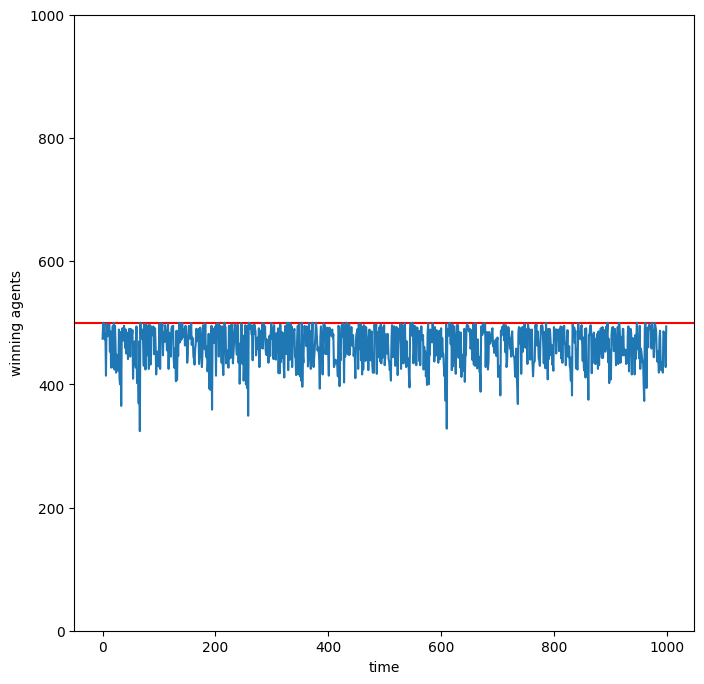

In [8]:
m = minority_game(1001, 1000, 4, 4)
m.run()
plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('winning agents')
plt.ylim([0,1000])
plt.axhline(y = 500, color='r', linestyle='-')
plt.plot(m.win_history)
plt.show()

### code profiling

In [6]:
%load_ext line_profiler
m = minority_game(1001, 100, 4, 4)
%lprun -f m.run_game m.run_game()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.901634 s
File: /tmp/ipykernel_741102/3320460978.py
Function: run_game at line 131

Line #      Hits         Time  Per Hit   % Time  Line Contents
   131                                               def run_game(self):
   132         1        451.0    451.0      0.0          mean_list = []
   133         1        120.0    120.0      0.0          stdd_list = []
   134         1         67.0     67.0      0.0          A_t = []            # records the total action over all the runs
   135       101      31588.0    312.8      0.0          for i in range(self.run_num):
   136       100      19152.0    191.5      0.0              num_of_buyers = 0
   137       100       8435.0     84.3      0.0              total_action = 0
   138    100200    8214748.0     82.0      0.9              for agent in self.agent_pool:
   139    100100  611590507.0   6109.8     67.8                  agent_action = agent.action(self.all_history[-self.memory:])
   140    100100   